<a href="https://colab.research.google.com/github/debashisdotchatterjee/India-Dengu-4-Ensemble-/blob/main/Dengu_4_Ensemble_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ============================================================
# India Dengue (2019–2025): Reality-Reflecting Ensemble
#   Stage A: Predict national total cases (Poisson HGB).
#   Stage B: Predict state share s_{i,t} = Y_{i,t} / Nat_t via logit-share GBM.
#   Blend:   Nonnegative least squares over {Nat*Share, Naive, Ratio-Growth}.
#   UQ:      Split-conformal on the blended predictor (90% PI).
#   Outputs: Colorful matplotlib figures + CSV tables + ZIP bundle.
# ============================================================


=== Evaluation by Year (Blended) ===
 year  n_obs         MAE    SMAPE   PoissonDev  PI_Coverage  PI_AvgWidth  nat_hat_t    w1_ml  w2_naive  w3_ratio
 2022     37 6838.695388 0.920707 12599.584446     0.918919 16008.783120   237830.0 0.424155  0.157028  0.418817
 2023     37 5933.097114 0.564482  5034.487223     0.864865 15140.473204   314054.0 0.319915  0.375203  0.304882
 2024     37 3530.248966 0.575232  3441.410523     0.918919 22118.551057   380158.0 0.308307  0.381117  0.310577
 2025     37 8947.053598 1.332815 10748.265626     0.945946 18751.434495   397534.0 0.291366  0.420002  0.288632


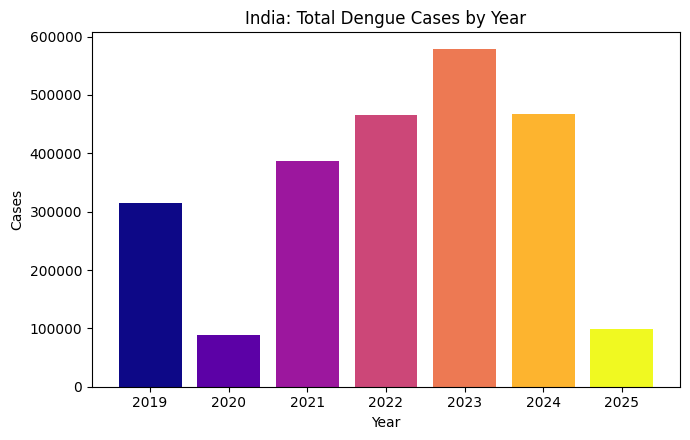

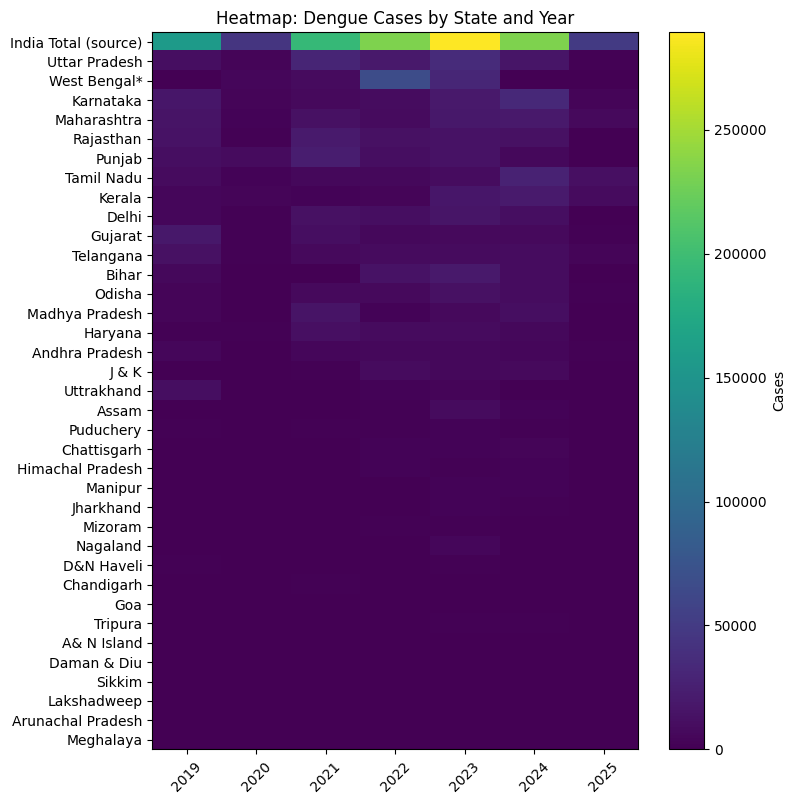

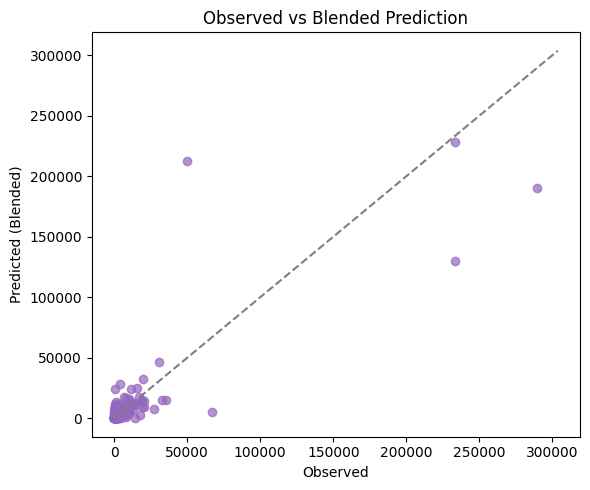

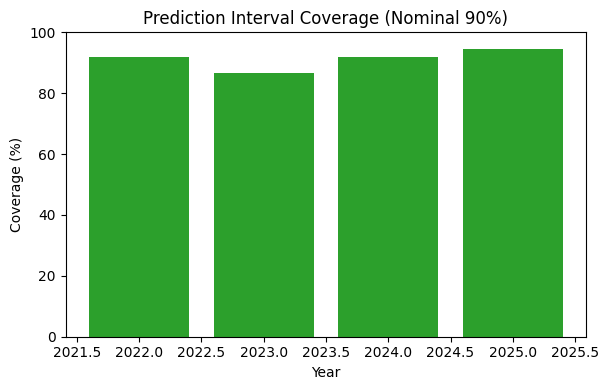

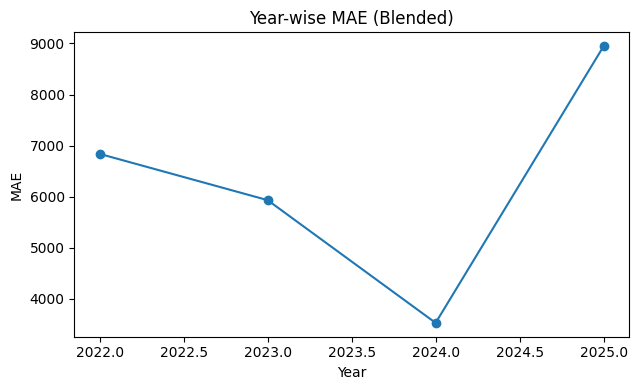

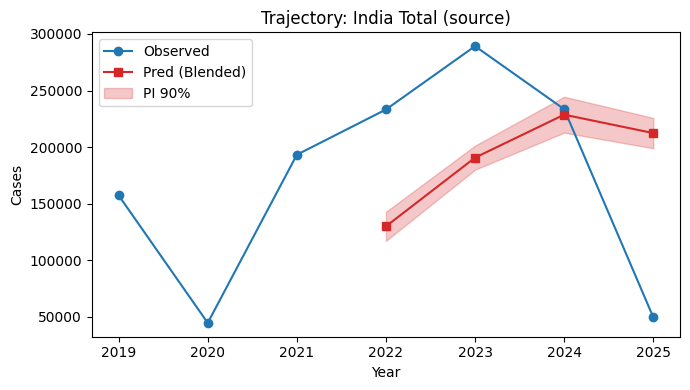

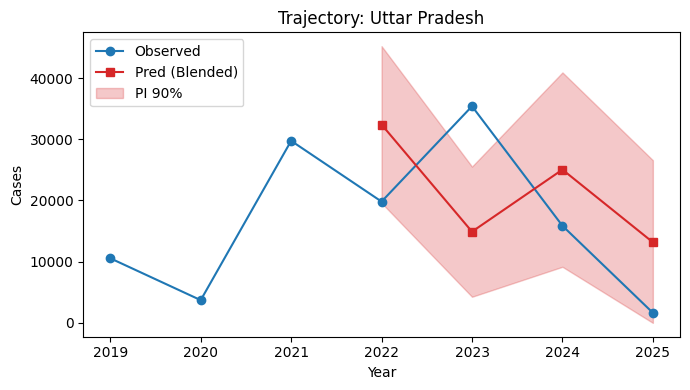

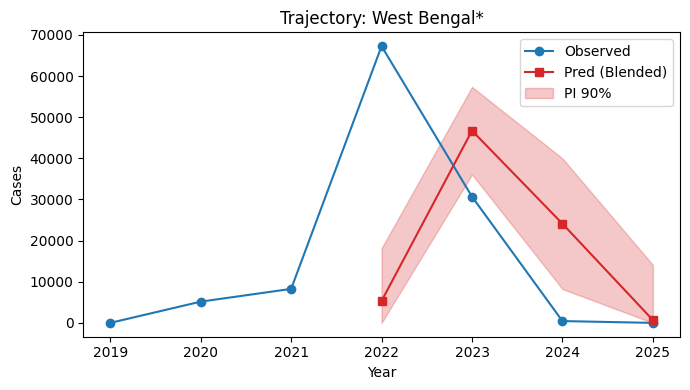

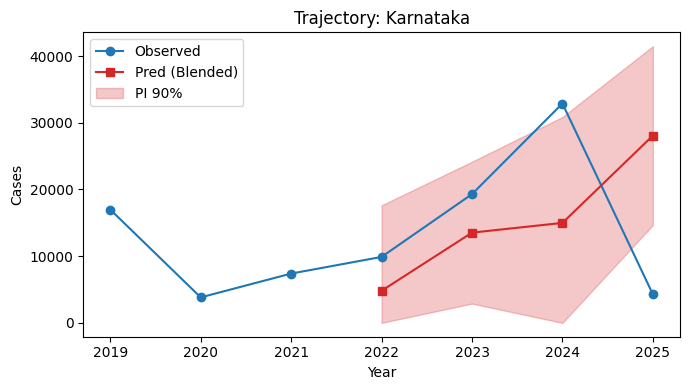

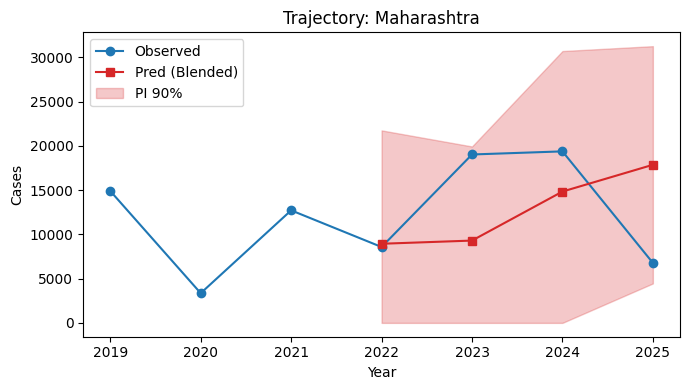

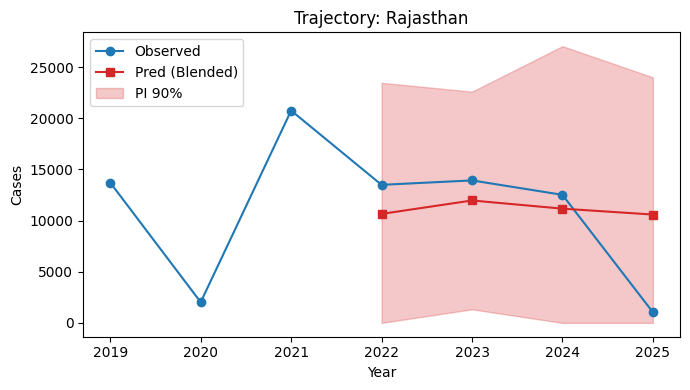

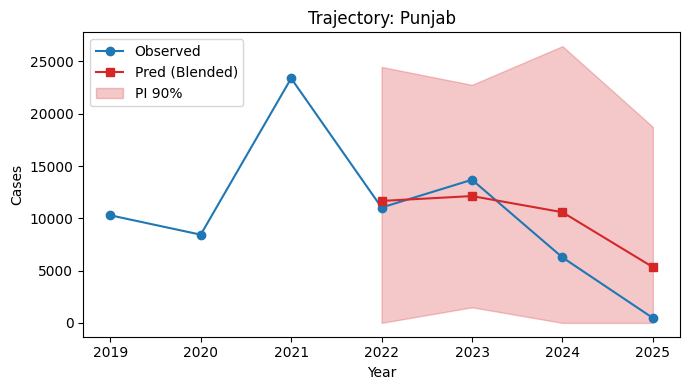

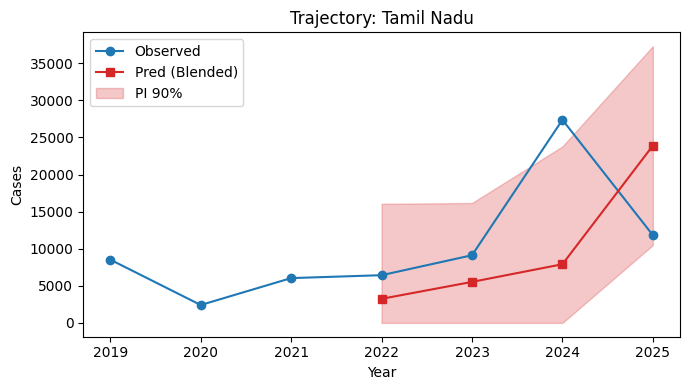

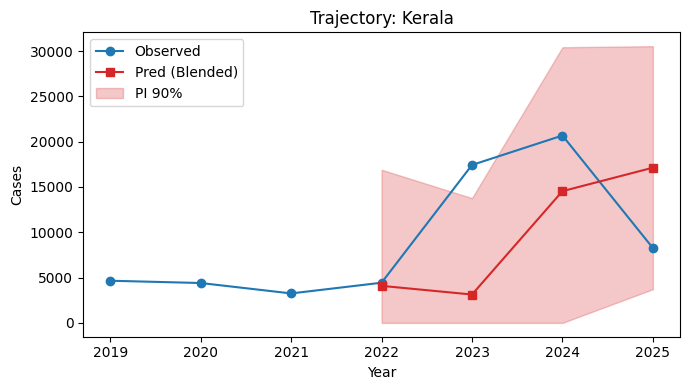

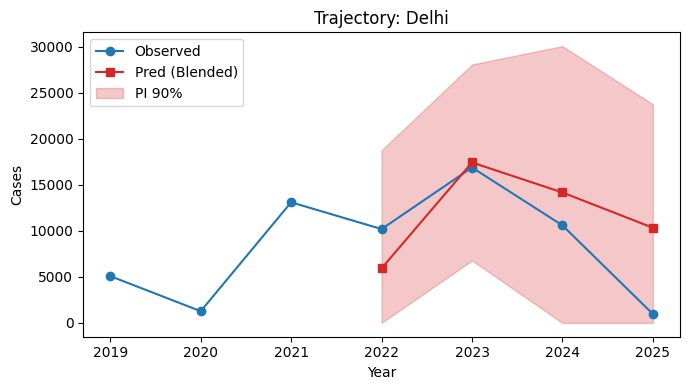

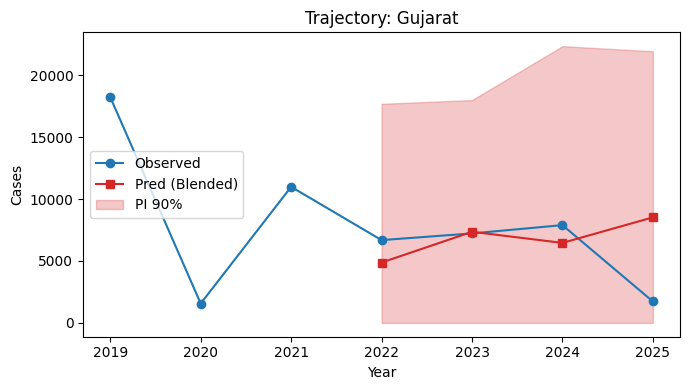

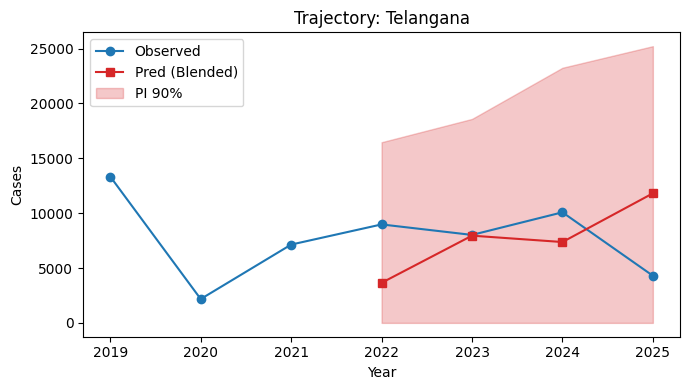

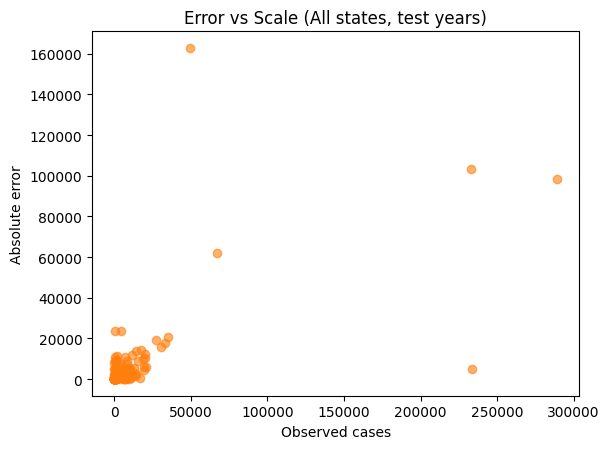

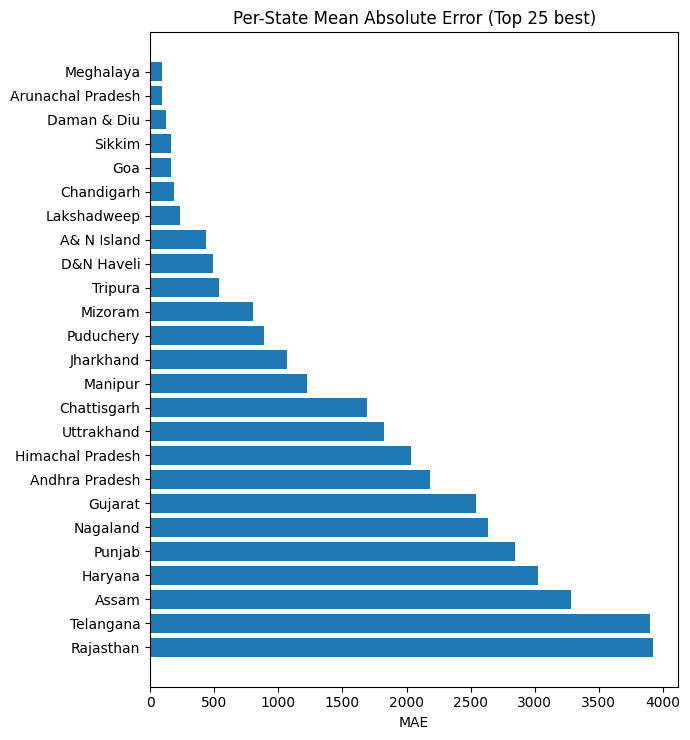


All done.
Zipped bundle: dengue_ensemble_outputs.zip
Figures in: outputs/figs
Tables in: outputs/tables


In [2]:
# ============================================================
# India Dengue (2019–2025): Reality-Reflecting Ensemble
#   Stage A: Predict national total cases (Poisson HGB).
#   Stage B: Predict state share s_{i,t} = Y_{i,t} / Nat_t via logit-share GBM.
#   Blend:   Nonnegative least squares over {Nat*Share, Naive, Ratio-Growth}.
#   UQ:      Split-conformal on the blended predictor (90% PI).
#   Outputs: Colorful matplotlib figures + CSV tables + ZIP bundle.
# ============================================================

import os, math, zipfile, warnings, textwrap, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_poisson_deviance
from numpy.linalg import lstsq

warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)
RNG = np.random.RandomState(2025)

# ---------------------------
# Paths
# ---------------------------
DATA_PATH = "dengue_india_state_2019_2025.xlsx"  # <-- adjust if needed
OUT_DIR = "outputs"; FIG_DIR = os.path.join(OUT_DIR, "figs"); TAB_DIR = os.path.join(OUT_DIR, "tables")
for d in [OUT_DIR, FIG_DIR, TAB_DIR]: os.makedirs(d, exist_ok=True)

# ---------------------------
# Utils
# ---------------------------
def save_show(fig, fname):
    path = os.path.join(FIG_DIR, fname)
    fig.tight_layout(); fig.savefig(path, dpi=220, bbox_inches="tight"); plt.show()

def nonneg_ls(X, y):
    """Simple non-negative least squares via projected gradient (fast and dependency-free)."""
    # Initialize
    w = np.maximum(0, lstsq(np.c_[X], y, rcond=None)[0])  # cold start
    w = np.maximum(w, 0)
    # small projected GD refinement
    lr = 1e-3
    for _ in range(2000):
        grad = (X.T @ (X @ w - y))/len(y)
        w = np.maximum(0, w - lr*grad)
    return w

def logit(p, eps=1e-6):
    p = np.clip(p, eps, 1-eps); return np.log(p/(1-p))

def inv_logit(x):
    return 1.0/(1.0 + np.exp(-x))

# ---------------------------
# Load
# ---------------------------
long = pd.read_excel(DATA_PATH, sheet_name="long_tidy")
df = long.rename(columns={
    "Affected States/UTs":"state", "Year":"year",
    "Cases":"cases", "Deaths":"deaths", "Provisional":"provisional"
})
df["state"] = df["state"].astype(str)
df["year"] = df["year"].astype(int)
df["cases"] = pd.to_numeric(df["cases"], errors="coerce").fillna(0.0)
df["deaths"] = pd.to_numeric(df["deaths"], errors="coerce").fillna(0.0)
df["provisional"] = df["provisional"].astype(bool)
df = df.sort_values(["state","year"]).reset_index(drop=True)

# ---------------------------
# Feature Engineering
# ---------------------------
# State lags
for L in [1,2,3]:
    df[f"lag{L}_cases"] = df.groupby("state")["cases"].shift(L)

# National totals + lags
nat = df.groupby("year", as_index=False)["cases"].sum().rename(columns={"cases":"nat_cases"})
nat["nat_lag1"] = nat["nat_cases"].shift(1)
nat["nat_lag2"] = nat["nat_cases"].shift(2)
nat["nat_lag3"] = nat["nat_cases"].shift(3)
df = df.merge(nat, on="year", how="left")

# Shares & share lags (computed only for training targets; lag features are safe)
df["share"] = df["cases"] / df["nat_cases"].replace(0, np.nan)
df["share_lag1"] = df.groupby("state")["share"].shift(1)
df["share_lag2"] = df.groupby("state")["share"].shift(2)

# Growth rates (state & nat)
df["g_state_1"] = (df["lag1_cases"]+1.0)/(df["lag2_cases"]+1.0)
df["g_nat_1"]   = (df["nat_lag1"]+1.0)/(df["nat_lag2"]+1.0)

# Composition feature: last year state share, and its momentum
df["share_mom"] = (df["share_lag1"]+1e-6)/(df["share_lag2"]+1e-6)

# Indexing features
df["year_idx"] = df["year"] - df["year"].min()
df["is_odd_year"] = (df["year"] % 2 == 1).astype(int)

# For predictive features, only lags allowed:
NAT_FEATS = ["nat_lag1","nat_lag2","nat_lag3","year_idx","is_odd_year"]
SHARE_FEATS = [
    "share_lag1","share_lag2","share_mom",
    "lag1_cases","lag2_cases","lag3_cases",
    "g_state_1","g_nat_1","year_idx","is_odd_year"
]

# Log transforms where sensible
for col in ["lag1_cases","lag2_cases","lag3_cases","nat_lag1","nat_lag2","nat_lag3"]:
    df[f"log1p_{col}"] = np.log1p(df[col].fillna(0))
NAT_FEATS = ["log1p_nat_lag1","log1p_nat_lag2","log1p_nat_lag3","year_idx","is_odd_year"]
SHARE_FEATS = [
    "share_lag1","share_lag2","share_mom",
    "log1p_lag1_cases","log1p_lag2_cases","log1p_lag3_cases",
    "g_state_1","g_nat_1","year_idx","is_odd_year"
]

# Drop rows missing minimal lags
dfm = df.dropna(subset=["lag1_cases","nat_lag1"]).copy()

# ---------------------------
# Models
# ---------------------------
def build_nat_model(seed=42):
    return HistGradientBoostingRegressor(
        loss="poisson",
        max_iter=400, learning_rate=0.06,
        min_samples_leaf=8, l2_regularization=0.1,
        random_state=seed
    )

def build_share_model(seed=43):
    # Prefer CatBoost if available (handles 'state' category well)
    try:
        from catboost import CatBoostRegressor
        # We'll use numerical features only here, but CatBoost can still help robustness
        return CatBoostRegressor(
            loss_function="RMSE", depth=6, learning_rate=0.06, n_estimators=600,
            random_state=seed, verbose=False
        )
    except Exception:
        # Fallback: GradientBoostingRegressor on logit-share (Gaussian loss is ok)
        return GradientBoostingRegressor(
            loss="squared_error", max_depth=3, n_estimators=800,
            learning_rate=0.05, random_state=seed
        )

# ---------------------------
# Rolling-origin evaluation
# ---------------------------
years = sorted(dfm["year"].unique())
eval_rows, pred_rows = [], []

for t in years:
    train_nat_mask = (dfm["year"] < t) & (~dfm["provisional"])
    test_nat_mask  = (dfm["year"] == t)

    # Need enough history
    if train_nat_mask.sum() < 50:
        continue

    # -------- Stage A: National total prediction --------
    # Train nat model on national aggregates (one row per year)
    nat_train = nat[nat["year"] < t].dropna(subset=["nat_lag1"])
    nat_test  = nat[nat["year"] == t]
    if nat_train.empty or nat_test.empty:
        continue

    X_nat_tr = nat_train[["nat_lag1","nat_lag2","nat_lag3"]].copy()
    for c in ["nat_lag1","nat_lag2","nat_lag3"]:
        X_nat_tr[f"log1p_{c}"] = np.log1p(X_nat_tr[c].fillna(0))
    X_nat_tr["year_idx"] = nat_train["year"] - nat["year"].min()
    X_nat_tr["is_odd_year"] = (nat_train["year"] % 2 == 1).astype(int)
    X_nat_tr = X_nat_tr[["log1p_nat_lag1","log1p_nat_lag2","log1p_nat_lag3","year_idx","is_odd_year"]].values
    y_nat_tr = nat_train["nat_cases"].values

    X_nat_te = nat_test[["nat_lag1","nat_lag2","nat_lag3"]].copy()
    for c in ["nat_lag1","nat_lag2","nat_lag3"]:
        X_nat_te[f"log1p_{c}"] = np.log1p(X_nat_te[c].fillna(0))
    X_nat_te["year_idx"] = nat_test["year"] - nat["year"].min()
    X_nat_te["is_odd_year"] = (nat_test["year"] % 2 == 1).astype(int)
    X_nat_te = X_nat_te[["log1p_nat_lag1","log1p_nat_lag2","log1p_nat_lag3","year_idx","is_odd_year"]].values

    nat_model = build_nat_model(seed=42)
    nat_model.fit(X_nat_tr, y_nat_tr)
    nat_hat_t = float(max(nat_model.predict(X_nat_te)[0], 0.0))  # predicted national total for year t

    # -------- Stage B: Share prediction (logit-share) --------
    # Train on all states with year < t (no provisional)
    train_share_mask = (dfm["year"] < t) & (~dfm["provisional"])
    share_train = dfm.loc[train_share_mask].dropna(subset=["share","share_lag1"]).copy()

    # Logit of share (target)
    y_share_tr = logit(share_train["share"].values, 1e-6)

    X_share_tr = share_train[SHARE_FEATS].copy().fillna(0.0).values

    share_model = build_share_model(seed=43)
    share_model.fit(X_share_tr, y_share_tr)

    # Predict for all states in year t
    test_rows = dfm.loc[dfm["year"] == t].copy()
    X_share_te = test_rows[SHARE_FEATS].copy().fillna(0.0).values
    logit_share_hat = share_model.predict(X_share_te)
    share_hat = np.clip(inv_logit(logit_share_hat), 0, 1)

    # Base ML predictor: nat_hat_t * share_hat
    yhat_ml = nat_hat_t * share_hat

    # -------- Baselines for blending --------
    # Baseline 1: Naive last-year carryover
    y_naive = test_rows["lag1_cases"].values

    # Baseline 2: Ratio-Growth — scale last-year by national growth
    nat_lag1_t = float(nat.loc[nat["year"] == (t-1), "nat_cases"].values[0]) if any(nat["year"]==(t-1)) else np.nan
    ratio = nat_hat_t / (nat_lag1_t + 1e-9) if pd.notnull(nat_lag1_t) else 1.0
    y_ratio = test_rows["lag1_cases"].values * ratio

    # Stack predictors -> blend on a calibration slice (year t-1)
    cal_rows = dfm.loc[(dfm["year"] == (t-1)) & (~dfm["provisional"])].copy()
    if len(cal_rows) >= 15:
        # Build components on cal year using models trained above
        X_share_cal = cal_rows[SHARE_FEATS].copy().fillna(0.0).values
        share_cal = np.clip(inv_logit(share_model.predict(X_share_cal)), 0, 1)
        # infer nat_hat for (t-1) using nat_model trained on < t (this is a leak-safe calibration)
        nat_cal = nat.loc[nat["year"] == (t-1)].copy()
        X_nat_cal = nat_cal[["nat_lag1","nat_lag2","nat_lag3"]].copy()
        for c in ["nat_lag1","nat_lag2","nat_lag3"]:
            X_nat_cal[f"log1p_{c}"] = np.log1p(X_nat_cal[c].fillna(0))
        X_nat_cal["year_idx"] = nat_cal["year"] - nat["year"].min()
        X_nat_cal["is_odd_year"] = (nat_cal["year"] % 2 == 1).astype(int)
        X_nat_cal = X_nat_cal[["log1p_nat_lag1","log1p_nat_lag2","log1p_nat_lag3","year_idx","is_odd_year"]].values
        nat_hat_cal = float(max(nat_model.predict(X_nat_cal)[0], 0.0))

        comp1 = nat_hat_cal * share_cal
        comp2 = cal_rows["lag1_cases"].values
        # Ratio for cal year using nat_hat_cal and nat_{t-2}
        nat_lag1_cal = float(nat.loc[nat["year"]==(t-2), "nat_cases"].values[0]) if any(nat["year"]==(t-2)) else np.nan
        ratio_cal = nat_hat_cal / (nat_lag1_cal + 1e-9) if pd.notnull(nat_lag1_cal) else 1.0
        comp3 = cal_rows["lag1_cases"].values * ratio_cal

        X_blend = np.vstack([comp1, comp2, comp3]).T
        y_blend = cal_rows["cases"].values
        w = nonneg_ls(X_blend, y_blend)
        w = w / (w.sum() + 1e-12)  # normalize for stability
    else:
        # Fallback weights
        w = np.array([0.6, 0.3, 0.1])

    # Final blended prediction
    X_te_stack = np.vstack([yhat_ml, y_naive, y_ratio]).T
    yhat_blend = np.maximum(X_te_stack @ w, 0.0)

    # -------- Conformal intervals on blended predictor --------
    if len(cal_rows) >= 15:
        # Build blended cal predictions
        X_share_cal = cal_rows[SHARE_FEATS].copy().fillna(0.0).values
        share_cal = np.clip(inv_logit(share_model.predict(X_share_cal)), 0, 1)
        # reuse nat_hat_cal above
        comp1c = nat_hat_cal * share_cal
        comp2c = cal_rows["lag1_cases"].values
        comp3c = cal_rows["lag1_cases"].values * ratio_cal
        yhat_cal_blend = np.maximum(np.vstack([comp1c, comp2c, comp3c]).T @ w, 0.0)
        cal_abs = np.abs(cal_rows["cases"].values - yhat_cal_blend)
        alpha = 0.10
        k = int(np.ceil((1-alpha) * (len(cal_abs) + 1))) - 1
        k = int(np.clip(k, 0, len(cal_abs)-1))
        q = np.partition(cal_abs, k)[k] if len(cal_abs)>0 else 0.0
    else:
        q = 0.0

    lo, hi = np.maximum(yhat_blend - q, 0.0), yhat_blend + q

    # Metrics
    y_true = test_rows["cases"].values
    mae = mean_absolute_error(y_true, yhat_blend)
    eps = 1e-9
    mpd = mean_poisson_deviance(y_true + eps, yhat_blend + eps)
    smape = float(np.mean(2*np.abs(yhat_blend - y_true)/(np.abs(yhat_blend)+np.abs(y_true)+eps)))
    coverage = float(np.mean((y_true >= lo) & (y_true <= hi))) if len(y_true) else np.nan
    avg_width = float(np.mean(hi - lo)) if len(y_true) else np.nan

    eval_rows.append({
        "year": int(t), "n_obs": int(test_nat_mask.sum()),
        "MAE": mae, "SMAPE": smape, "PoissonDev": mpd,
        "PI_Coverage": coverage, "PI_AvgWidth": avg_width,
        "nat_hat_t": nat_hat_t, "w1_ml": w[0], "w2_naive": w[1], "w3_ratio": w[2]
    })

    # Store predictions
    fold = test_rows[["state","year","cases"]].copy()
    fold["pred_ml"] = yhat_ml
    fold["pred_naive"] = y_naive
    fold["pred_ratio"] = y_ratio
    fold["pred_blend"] = yhat_blend
    fold["pi_lo"] = lo; fold["pi_hi"] = hi
    pred_rows.append(fold)

# Tables
eval_df = pd.DataFrame(eval_rows).sort_values("year")
preds_df = pd.concat(pred_rows, ignore_index=True) if pred_rows else pd.DataFrame()
eval_df.to_csv(os.path.join(TAB_DIR, "evaluation_by_year.csv"), index=False)
preds_df.to_csv(os.path.join(TAB_DIR, "predictions_all.csv"), index=False)

print("\n=== Evaluation by Year (Blended) ===")
print(eval_df.to_string(index=False))

# ---------------------------
# Plots (colorful)
# ---------------------------
# Nat totals bars
nat_year = df.groupby("year", as_index=False)["cases"].sum()
fig = plt.figure(figsize=(7,4.5))
cmap = plt.cm.plasma
colors = [cmap(i/max(1, len(nat_year)-1)) for i in range(len(nat_year))]
plt.bar(nat_year["year"], nat_year["cases"], color=colors)
plt.title("India: Total Dengue Cases by Year")
plt.xlabel("Year"); plt.ylabel("Cases")
save_show(fig, "01_nat_cases_by_year.png")

# Heatmap state x year
pvt = df.pivot_table(index="state", columns="year", values="cases", aggfunc="sum").fillna(0.0)
state_order = pvt.sum(axis=1).sort_values(ascending=False).index
pvt = pvt.loc[state_order]
fig = plt.figure(figsize=(8, max(6, 0.22*len(state_order))))
plt.imshow(pvt.values, aspect="auto", cmap="viridis")
plt.colorbar(label="Cases")
plt.yticks(range(len(pvt.index)), pvt.index)
plt.xticks(range(len(pvt.columns)), pvt.columns, rotation=45)
plt.title("Heatmap: Dengue Cases by State and Year")
save_show(fig, "02_heatmap_state_year.png")

# Obs vs Pred (blended)
if not preds_df.empty:
    fig = plt.figure(figsize=(6,5))
    plt.scatter(preds_df["cases"], preds_df["pred_blend"], alpha=0.7, c="tab:purple")
    mx = max(preds_df["cases"].max(), preds_df["pred_blend"].max())*1.05
    plt.plot([0,mx],[0,mx], "--", c="tab:gray")
    plt.xlabel("Observed"); plt.ylabel("Predicted (Blended)")
    plt.title("Observed vs Blended Prediction")
    save_show(fig, "03_obs_vs_pred_blended.png")

# Coverage by year
if not eval_df.empty:
    fig = plt.figure(figsize=(6.2,4))
    plt.bar(eval_df["year"], 100*eval_df["PI_Coverage"], color="tab:green")
    plt.ylim(0,100); plt.ylabel("Coverage (%)"); plt.xlabel("Year")
    plt.title("Prediction Interval Coverage (Nominal 90%)")
    save_show(fig, "04_coverage_by_year.png")

# Year-wise MAE
if not eval_df.empty:
    fig = plt.figure(figsize=(6.5,4))
    plt.plot(eval_df["year"], eval_df["MAE"], marker="o")
    plt.title("Year-wise MAE (Blended)"); plt.xlabel("Year"); plt.ylabel("MAE")
    save_show(fig, "05_mae_by_year.png")

# State trajectories (top 12)
top_states = df.groupby("state")["cases"].sum().sort_values(ascending=False).head(12).index.tolist()
for st in top_states:
    sub = df[df["state"]==st][["year","cases"]].copy()
    if not preds_df.empty:
        sub = sub.merge(preds_df[preds_df["state"]==st][["year","pred_blend","pi_lo","pi_hi"]], on="year", how="left")
    fig = plt.figure(figsize=(7,4))
    plt.plot(sub["year"], sub["cases"], marker="o", label="Observed", c="tab:blue")
    if sub["pred_blend"].notna().any():
        plt.plot(sub["year"], sub["pred_blend"], marker="s", label="Pred (Blended)", c="tab:red")
        if sub["pi_lo"].notna().any():
            plt.fill_between(sub["year"], sub["pi_lo"], sub["pi_hi"], alpha=0.25, color="tab:red", label="PI 90%")
    plt.title(f"Trajectory: {st}"); plt.xlabel("Year"); plt.ylabel("Cases"); plt.legend()
    save_show(fig, f"06_traj_{st.replace(' ','_')}.png")

# Error vs size
if not preds_df.empty:
    tmp = preds_df.copy()
    tmp["abs_err"] = np.abs(tmp["cases"] - tmp["pred_blend"])
    fig = plt.figure(figsize=(6.2,4.6))
    plt.scatter(tmp["cases"], tmp["abs_err"], alpha=0.6, c="tab:orange")
    plt.xlabel("Observed cases"); plt.ylabel("Absolute error")
    plt.title("Error vs Scale (All states, test years)")
    save_show(fig, "07_error_vs_scale.png")

# Per-state MAE across all test years
if not preds_df.empty:
    dd = preds_df.copy()
    dd["abs_err"] = np.abs(dd["cases"] - dd["pred_blend"])
    per_state = dd.groupby("state", as_index=False)["abs_err"].mean().sort_values("abs_err")
    per_state.to_csv(os.path.join(TAB_DIR, "per_state_mae.csv"), index=False)

    nshow = min(25, len(per_state))
    fig = plt.figure(figsize=(7, max(6, 0.3*nshow)))
    plt.barh(per_state["state"].head(nshow)[::-1], per_state["abs_err"].head(nshow)[::-1])
    plt.title("Per-State Mean Absolute Error (Top 25 best)"); plt.xlabel("MAE")
    save_show(fig, "08_per_state_mae.png")

# ---------------------------
# README + ZIP
# ---------------------------
readme_txt = f"""
Reality-Reflecting Ensemble Outputs
==================================
Method:
 - Two-stage model: national total (Poisson GBM) × state share (logit-GBM).
 - Nonnegative-blended ensemble: {{Nat×Share, Last-year naive, Nat-growth ratio}}.
 - Split-conformal intervals (90%) on BLENDED predictions.
 - Rolling-origin by year (train < t, test = t), excluding provisional rows from training.

Key Tables:
 - evaluation_by_year.csv
 - predictions_all.csv
 - per_state_mae.csv

Key Figures:
 - 01_nat_cases_by_year.png
 - 02_heatmap_state_year.png
 - 03_obs_vs_pred_blended.png
 - 04_coverage_by_year.png
 - 05_mae_by_year.png
 - 06_traj_<STATE>.png  (top 12 states)
 - 07_error_vs_scale.png
 - 08_per_state_mae.png
"""
with open(os.path.join(OUT_DIR, "README.txt"), "w") as f:
    f.write(textwrap.dedent(readme_txt))

zip_path = "dengue_ensemble_outputs.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for root, _, files in os.walk(OUT_DIR):
        for fn in files:
            full = os.path.join(root, fn)
            arc  = os.path.relpath(full, OUT_DIR)
            zf.write(full, arcname=arc)

print("\nAll done.")
print(f"Zipped bundle: {zip_path}")
print(f"Figures in: {FIG_DIR}")
print(f"Tables in: {TAB_DIR}")
